<a href="https://colab.research.google.com/github/Daja1221/Daja1221/blob/main/511716012_HW4_%E8%A8%B1%E4%BB%81%E9%B4%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import time
import tensorflow as tf
import joblib
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import Flatten
import matplotlib.pyplot as plt
from google.colab import drive

In [31]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Correct file path after mounting Google Drive
df = pd.read_csv('/content/drive/MyDrive/amazon.csv')
df = df[['Score', 'Text']]
df = df.head(10000)
print(df)

      Score                                               Text
0         5  I have bought several of the Vitality canned d...
1         1  Product arrived labeled as Jumbo Salted Peanut...
2         4  This is a confection that has been around a fe...
3         2  If you are looking for the secret ingredient i...
4         5  Great taffy at a great price.  There was a wid...
...     ...                                                ...
9995      1  we switched from the advance similac to the or...
9996      5  Like the bad reviews say, the organic formula ...
9997      5  I wanted to solely breastfeed but was unable t...
9998      5  i love the fact that i can get this delieved t...
9999      4  We have a 7 week old... He had gas and constip...

[10000 rows x 2 columns]


In [33]:
#將 "Score" 欄位內值大於等於4的轉成1，其餘轉成0
df['Score']=np.where(df['Score']>=4, 1, 0)
df.head(10)

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...
5,1,I got a wild hair for taffy and ordered this f...
6,1,This saltwater taffy had great flavors and was...
7,1,This taffy is so good. It is very soft and ch...
8,1,Right now I'm mostly just sprouting this so my...
9,1,This is a very healthy dog food. Good for thei...


In [34]:
print('Checking for Null Values: ',df.isnull().sum())
print('number of stars 1: ', df.loc[df['Score'] == 1].count())
print('number of stars 0: ', df.loc[df['Score'] == 0].count())


Checking for Null Values:  Score    0
Text     0
dtype: int64
number of stars 1:  Score    7616
Text     7616
dtype: int64
number of stars 0:  Score    2384
Text     2384
dtype: int64


In [35]:
#將數據集分成Ｘ和Ｙ進行預測
x = df['Text']
y = df['Score']
print(x.head())
print(y.head())

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object
0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64


In [36]:
df['Score_info'] = np.where(df['Score'] ==1,'postive','negative')
df.head(5)

,Score,Text,Score_info
0,1,I have bought several of the Vitality canned d...,postive
1,0,Product arrived labeled as Jumbo Salted Peanut...,negative
2,1,This is a confection that has been around a fe...,postive
3,0,If you are looking for the secret ingredient i...,negative
4,1,Great taffy at a great price. There was a wid...,postive


<Axes: xlabel='Score', ylabel='count'>

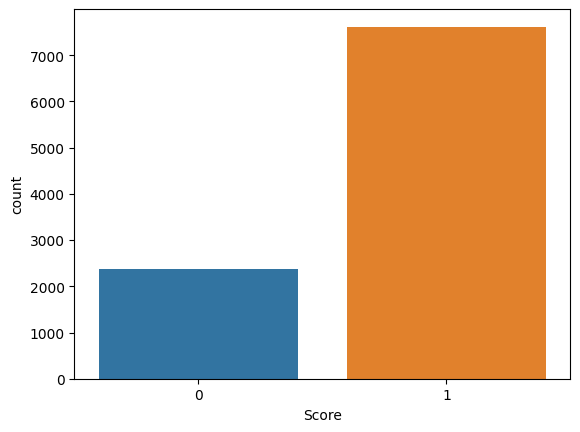

In [37]:
sns.countplot(x = df['Score'],data = df )

<Axes: xlabel='Score_info', ylabel='count'>

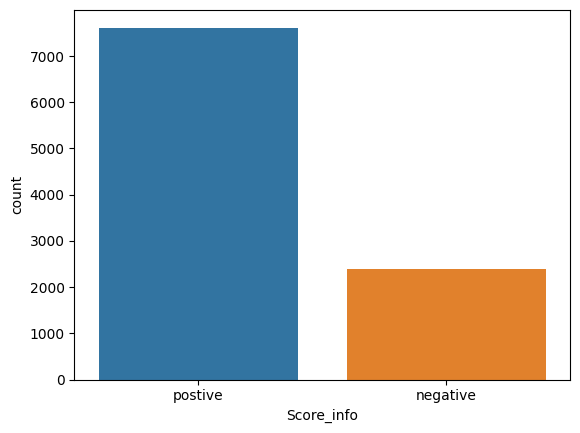

In [38]:
sns.countplot(x = df['Score_info'],data = df )

In [39]:
# Split the text into words
df['Text'] = df['Text'].apply(lambda x: x.split())

# b. Remove stop words
df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in ENGLISH_STOP_WORDS])

# c. Text to Vector (using TfidfVectorizer)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Text'].apply(lambda x: ' '.join(x)))



In [40]:
# Check if the vocabulary is not empty after vectorization
if X.shape[1] == 0:
    empty_docs_after_vectorization = df[df['Text'].apply(len) == 0]
    print("Documents causing the issue after vectorization:")
    print(empty_docs_after_vectorization)
    raise ValueError("After vectorization, the vocabulary is empty. Adjust your preprocessing steps.")

In [41]:
# Encode the target variable
label_encoder = LabelEncoder()
df['Score'] = label_encoder.fit_transform(df['Score'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Score'], test_size=0.2, random_state=42)

In [42]:
# Task 2: Building Models
# a. CNN Model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(vectorizer.get_feature_names_out()), output_dim=100, input_length=X.shape[1]))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.7))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 18783, 100)        1878300   
                                                                 
 conv1d_1 (Conv1D)           (None, 18781, 64)         19264     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9390, 64)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 600960)            0         
                                                                 
 dense_4 (Dense)             (None, 50)                30048050  
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                      

In [43]:
# b. LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(vectorizer.get_feature_names_out()), output_dim=100, input_length=X.shape[1]))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dropout(0.7))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 18783, 100)        1878300   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1963801 (7.49 MB)
Trainable params: 1963801 (7.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [44]:
# Task 3: Train the Models
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

history_cnn = model_cnn.fit(X_train_dense, y_train, epochs=5, batch_size=64, validation_data=(X_test_dense, y_test))
history_lstm = model_lstm.fit(X_train_dense, y_train, epochs=5, batch_size=64, validation_data=(X_test_dense, y_test))


Epoch 1/5
125/125 [==============================] - 21s 158ms/step - loss: 0.6216 - accuracy: 0.7523 - val_loss: 0.5616 - val_accuracy: 0.7540
Epoch 2/5
125/125 [==============================] - 20s 156ms/step - loss: 0.5847 - accuracy: 0.7635 - val_loss: 0.6037 - val_accuracy: 0.7540
Epoch 3/5
125/125 [==============================] - 19s 155ms/step - loss: 0.5734 - accuracy: 0.7635 - val_loss: 0.5685 - val_accuracy: 0.7540
Epoch 4/5
125/125 [==============================] - 19s 153ms/step - loss: 0.5730 - accuracy: 0.7635 - val_loss: 0.5614 - val_accuracy: 0.7540
Epoch 5/5
125/125 [==============================] - 19s 154ms/step - loss: 0.5722 - accuracy: 0.7635 - val_loss: 0.5588 - val_accuracy: 0.7540
Epoch 1/5
125/125 [==============================] - 93s 732ms/step - loss: 0.5682 - accuracy: 0.7613 - val_loss: 0.5586 - val_accuracy: 0.7540
Epoch 2/5
125/125 [==============================] - 90s 720ms/step - loss: 0.5588 - accuracy: 0.7635 - val_loss: 0.5582 - val_accuracy:

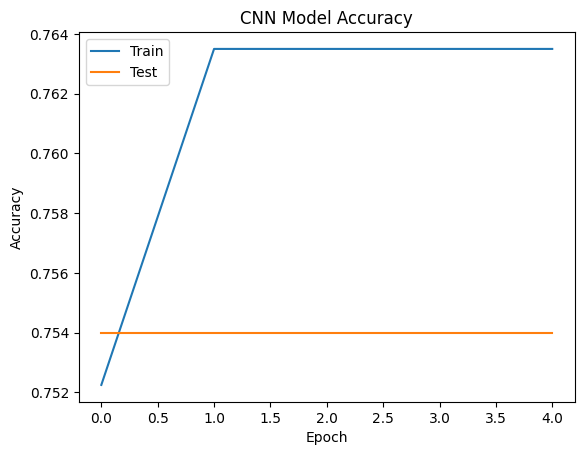

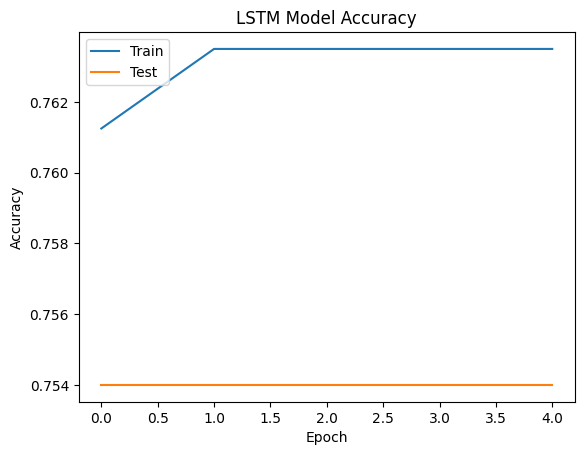

In [45]:
# c. plot 出訓練過程中的 Accuracy 與 Loss 值變化
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history_cnn, 'CNN')
plot_history(history_lstm, 'LSTM')

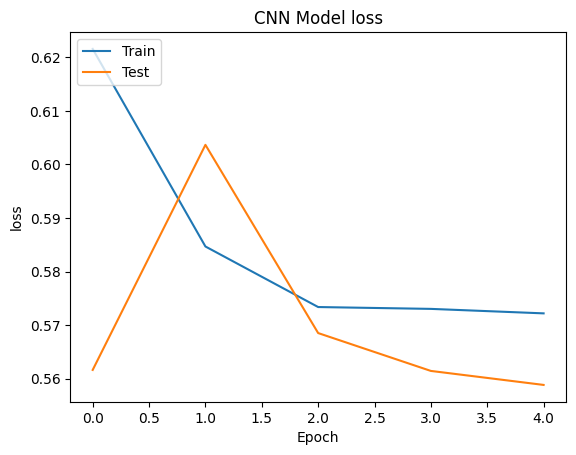

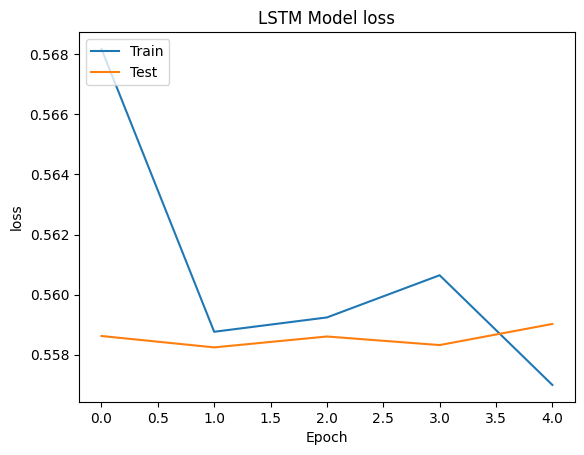

In [46]:
# c. plot 出訓練過程中的 Accuracy 與 Loss 值變化
def plot_history(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history_cnn, 'CNN')
plot_history(history_lstm, 'LSTM')

In [47]:
# Assuming you used fit_transform on a DataFrame during training
# Load the test data
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')  # Adjust the path

X_test = vectorizer.transform(df_test['Text'].apply(lambda x: ' '.join(x)))
y_pred_cnn = model_cnn.predict(X_test)
y_pred_lstm = model_lstm.predict(X_test)

# Convert probabilities to binary predictions
y_pred_cnn = [1 if pred >= 0.5 else 0 for pred in y_pred_cnn]
y_pred_lstm = [1 if pred >= 0.5 else 0 for pred in y_pred_lstm]

# Calculate Accuracy
accuracy_cnn = sum(y_pred_cnn == df_test['Text']) / len(df_test)
accuracy_lstm = sum(y_pred_lstm == df_test['Text']) / len(df_test)

print(f'CNN Model Accuracy: {accuracy_cnn}')
print(f'LSTM Model Accuracy: {accuracy_lstm}')

157/157 [==============================] - 33s 206ms/step
CNN Model Accuracy: 0.0
LSTM Model Accuracy: 0.0


In [ ]:
# Transform the test data using the same vectorizer
X_kaggle = vectorizer.transform(df['Text'].apply(lambda x: ' '.join(x)))
# Assuming you have loaded or defined y_kaggle for the Kaggle test data
y_kaggle = label_encoder.transform(df['Score'])  # Assuming 'Score' is the target column

# Reshape X_kaggle if needed (especially for CNN and LSTM models)
# For example, for CNN:
# X_kaggle = X_kaggle.reshape(X_kaggle.shape[0], X_kaggle.shape[1], 1)

# Convert to dense array for evaluation
X_kaggle_dense = X_kaggle.toarray()

# Evaluate the CNN model
accuracy_cnn = model_cnn.evaluate(X_kaggle_dense, y_kaggle)[1]
print(f'Accuracy for CNN model on Kaggle test data: {accuracy_cnn}')

# Evaluate the LSTM model
accuracy_lstm = model_lstm.evaluate(X_kaggle_dense, y_kaggle)[1]
print(f'Accuracy for LSTM model on Kaggle test data: {accuracy_lstm}')

313/313 [==============================] - 10s 22ms/step - loss: 0.5511 - accuracy: 0.7617
Accuracy for CNN model on Kaggle test data: 0.761681318283081
